<a href="https://colab.research.google.com/github/tomcaputo/aws_product_embeddings/blob/main/Product_Embeddings_Two_Tower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Product Embedddings with the Amazon 2023

Questions
- How to handle max length of context window



TODO
- MLFlow logging
- test and train script
- How to update model with new users with transfer learning



## Retrieval - algorithm scales well: focused on recall
Supervised
- Matrix Factorization
- NCF
- Two Towers

Embed --> VectorDB --> Retrieve via similarity

## Reranker -- employ more sophisticed models: focused on precision
- Transformer
- XGBoost



## Notebook Setup

In [ ]:
!pip install faiss-gpu
!pip install datasets #evaluate torch
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

import json
import copy

from datasets import load_dataset

import faiss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.preprocessing import LabelEncoder

In [ ]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/RAG/")
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/RAG/'

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


## Amazon 2023 data set


The Amazon Reviews 2023 dataset, collected to ensure up-to-date training corpora for LLMs, is significantly more extensive than its predecessors. It contains millions of reviews with accompanying text, ratings, and timestamps, making it ideal for benchmarking recommender systems.


*   It features 3.18 times more items and 2.4 times more reviews and metadata

*   The metadata is richer and cleaner, parsed from HTML into JSON, with more descriptive fields and multi-modal content such as videos and images

  [Full Description](https://amazon-reviews-2023.github.io/)

There are two files that are used:



1.   `amazon_2023_full.parquet`: contains reviews
2.   `amazon_2023_metadata.parquet`: contains metadata on products



## Import Data

In [ ]:

# Load interaction data
download_interaction_data = False
if download_interaction_data:
  interaction_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", trust_remote_code=True)
  print(interaction_dataset["full"][0])
  interaction_dataset["full"].to_parquet(data_dir + 'amazon_2023_full.parquet')

create_downsmaple = False
if create_downsmaple:
  interaction_df = pd.read_parquet(data_dir + 'amazon_2023_full.parquet')
  downsample_frac = .005

  # identify downsample IDs
  user_ids = pd.Series(interaction_df['user_id']).unique()
  rand_ids = np.random.uniform(0, 1, len(user_ids))
  user_ids = pd.Series(user_ids[rand_ids < downsample_frac])

  # downsample
  interaction_df[interaction_df['user_id'].isin(user_ids)].to_parquet(data_dir + 'amazon_2023_downsampled.parquet')

interaction_df = pd.read_parquet(data_dir + 'amazon_2023_downsampled.parquet')


In [ ]:
interaction_df.head()

In [ ]:
download_metadata = False
if download_metadata:
  metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", trust_remote_code=True)
  print(metadata_dataset["full"][0])
  metadata_dataset["full"].to_parquet(data_dir + 'amazon_2023_metadata.parquet')

create_downsmaple = False
if create_downsmaple:
  metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata.parquet')

  # identify downsample IDs
  item_ids = pd.Series(interaction_df['parent_asin']).unique()

  # downsample
  metadata_df[metadata_df['parent_asin'].isin(item_ids)].to_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

## EDA

In [ ]:
print(f"""users: {interaction_df.user_id.nunique()}
items: {interaction_df.asin.nunique()}""")

In [ ]:
# unique products purchased per user
per_user_engagement = interaction_df.groupby('user_id')['asin'].count().value_counts().sort_index()
per_user_engagement.plot()
plt.yscale('log')

In [ ]:
per_user_engagement[per_user_engagement.index<20].plot(kind='bar', figsize=(10, 5))

In [ ]:
interaction_df.head()

In [ ]:
metadata_df.head()

## Feature Engineering

In [ ]:
# convert price to numerical
metadata_df['price'] = metadata_df['price'].str.replace('[^0-9\.]', '', regex=True)\
                                .replace('', np.nan).astype(float)\
                                .fillna(0)

In [ ]:
features = ['average_rating', 'rating_number', 'price']

## Basic Two Towers


### Data Preperation

In [ ]:
train_interactions = interaction_df.copy()
train_metadata = metadata_df.copy()

In [ ]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()
parent_product_encoder = LabelEncoder()

train_interactions['user_id'] = user_encoder.fit_transform(train_interactions['user_id'])
train_interactions['asin'] = product_encoder.fit_transform(train_interactions['asin'])
train_metadata['parent_asin'] = parent_product_encoder.fit_transform(train_metadata['parent_asin'])
train_interactions['parent_asin'] = parent_product_encoder.transform(train_interactions['parent_asin'])

In [ ]:
item_metadata_tensor = torch.tensor(train_metadata[features].astype(float).values)

user_tensor = torch.tensor(train_interactions['user_id'].astype(int).values)
product_tensor = torch.tensor(train_interactions['asin'].astype(int).values)
rating_tensor = torch.tensor((train_interactions['rating'].values>=0).astype(float))
parent_idx_tensor = torch.tensor(train_interactions['parent_asin'].astype(int).values)

# Convert to torch sparse tensor
interaction_tensor = torch.sparse_coo_tensor(
    indices=torch.tensor(torch.stack([user_tensor, product_tensor])),
    values=torch.tensor(rating_tensor),
)

In [ ]:
class AmazonDataset(Dataset):

  def __init__(self, item_metadata, parent_idx_tensor, interaction_matrix):


    self.item_metadata = item_metadata
    self.interactions = interaction_matrix
    self.parent_idx = parent_idx_tensor
    self.values = self.interactions._values()
    self.indices = self.interactions._indices()


  def __len__(self):
    return self.values.size(0)

  def __getitem__(self, idx):

    # context
    user_idx = self.indices[0, idx]
    item_idx = self.indices[1, idx]

    parent_idx = self.parent_idx[idx]

    # interactions
    item_meta = self.item_metadata[parent_idx]

    # target
    rating = self.values[idx]

    return user_idx, item_idx, rating, item_meta

In [ ]:
az_dataset = AmazonDataset(item_metadata_tensor,
                           parent_idx_tensor,
                           interaction_tensor)

In [ ]:
az_dataset.__getitem__(1)

(tensor(23925),
 tensor(987),
 tensor(1., dtype=torch.float64),
 tensor([  4., 556.,   0.], dtype=torch.float64))

### Models

In [ ]:
class TwoTowerNCF(pl.LightningModule):

  def __init__(self, n_users, n_items,
               item_metadata_dim,
               embedding_size, metadata_embedding_size,
               layers=1):

    super().__init__()

    # user tower
    self.user_tower_embedding = nn.Embedding(n_users, embedding_size)
    #self.user_metadata = nn.Embedding(user_metadata_dim, metadata_embedding_size)
    #self.user_tower_output = nn.Linear(embedding_size + metadata_embedding_size, embedding_size)

    # item tower
    self.item_embedding = nn.Embedding(n_items, embedding_size)
    self.item_metadata = nn.Linear(item_metadata_dim, metadata_embedding_size)
    self.item_concat_embedding = nn.Linear(embedding_size + metadata_embedding_size, embedding_size)

    self.user_tower_fc_layers = []
    self.item_tower_fc_layers = []

    input_dims = [embedding_size // i for i in range(1, layers+1)]
    output_dims = [embedding_size // (i+1) for i in range(1, layers+1)]

    for i in range(layers):
      self.user_tower_fc_layers.append(nn.Linear(input_dims[i], output_dims[i]))
      self.item_tower_fc_layers.append(nn.Linear(input_dims[i], output_dims[i]))

      self.user_tower_fc_layers.append(nn.BatchNorm1d(output_dims[i]))
      self.item_tower_fc_layers.append(nn.BatchNorm1d(output_dims[i]))

      self.user_tower_fc_layers.append(nn.ReLU())
      self.item_tower_fc_layers.append(nn.ReLU())


    self.user_tower_fc_layers = nn.Sequential(*self.user_tower_fc_layers)
    self.item_tower_fc_layers = nn.Sequential(*self.item_tower_fc_layers)

  def forward(self, user_idx, product_idx, item_meta, target):

    # user tower base
    user_x = self.user_tower_embedding(user_idx)
    user_x = F.relu(user_x)


    # item tower base
    item_x = self.item_embedding(product_idx)
    item_meta_x = self.item_metadata(item_meta.float())
    item_x = torch.cat([item_x, item_meta_x], dim=1)
    item_x = self.item_concat_embedding(item_x)
    item_x = F.relu(item_x)

    # tower layers
    item_x = self.item_tower_fc_layers(item_x)
    user_x = self.user_tower_fc_layers(user_x)

    # cosine similarity
    output = F.cosine_similarity(item_x, user_x)
    output = torch.sigmoid(output)

    return output

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log_dict({'train_loss': loss}, prog_bar=True, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss)
    return loss

  def common_step(self, batch, batch_idx):
    user_idx, product_idx, rating, item_meta = batch
    output = self.forward(user_idx, product_idx, item_meta, rating)
    loss = F.binary_cross_entropy(output, rating.float())
    return loss

  def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=.001)



In [ ]:
class SaveMetricsCallback(pl.Callback):

    def __init__(self):
      super().__init__()
      self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the logs directly from the logger
        each_me = copy.deepcopy(trainer.callback_metrics['train_loss']).cpu().numpy()
        self.metrics.append(each_me)
        print(f"Epoch {trainer.current_epoch}: {trainer.callback_metrics}")


In [ ]:
callback = SaveMetricsCallback()
trainer = pl.Trainer(max_epochs=10, callbacks=[callback])

n_items = interaction_df.asin.nunique()
n_users = interaction_df.user_id.nunique()
item_metadata_dim = item_metadata_tensor.size(1)
embedding_size = 16

train_loader = DataLoader(az_dataset, batch_size=1024, shuffle=True)

two_tower_model = TwoTowerNCF(n_users, n_items,
               item_metadata_dim,
               embedding_size, item_metadata_dim,
               layers=3)

trainer.fit(two_tower_model, train_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type       | Params | Mode 
-------------------------------------------------------------
0 | user_tower_embedding  | Embedding  | 825 K  | train
1 | item_embedding        | Embedding  | 1.8 M  | train
2 | item_metadata         | Linear     | 12     | train
3 | item_concat_embedding | Linear     | 320    | train
4 | user_tower_fc_layers  | Sequential | 239    | train
5 | item_tower_fc_layers  | Sequential | 239    | train
-------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.587    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytor

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: {'train_loss': tensor(0.4734, device='cuda:0'), 'train_loss_step': tensor(0.4420, device='cuda:0'), 'train_loss_epoch': tensor(0.4734, device='cuda:0')}
Epoch 1: {'train_loss': tensor(0.4243, device='cuda:0'), 'train_loss_step': tensor(0.4089, device='cuda:0'), 'train_loss_epoch': tensor(0.4243, device='cuda:0')}
Epoch 2: {'train_loss': tensor(0.3963, device='cuda:0'), 'train_loss_step': tensor(0.3885, device='cuda:0'), 'train_loss_epoch': tensor(0.3963, device='cuda:0')}
Epoch 3: {'train_loss': tensor(0.3736, device='cuda:0'), 'train_loss_step': tensor(0.3664, device='cuda:0'), 'train_loss_epoch': tensor(0.3736, device='cuda:0')}
Epoch 4: {'train_loss': tensor(0.3581, device='cuda:0'), 'train_loss_step': tensor(0.3471, device='cuda:0'), 'train_loss_epoch': tensor(0.3581, device='cuda:0')}
Epoch 5: {'train_loss': tensor(0.3554, device='cuda:0'), 'train_loss_step': tensor(0.3554, device='cuda:0'), 'train_loss_epoch': tensor(0.3554, device='cuda:0')}
Epoch 6: {'train_loss': tens

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: {'train_loss': tensor(0.3161, device='cuda:0'), 'train_loss_step': tensor(0.3160, device='cuda:0'), 'train_loss_epoch': tensor(0.3161, device='cuda:0')}


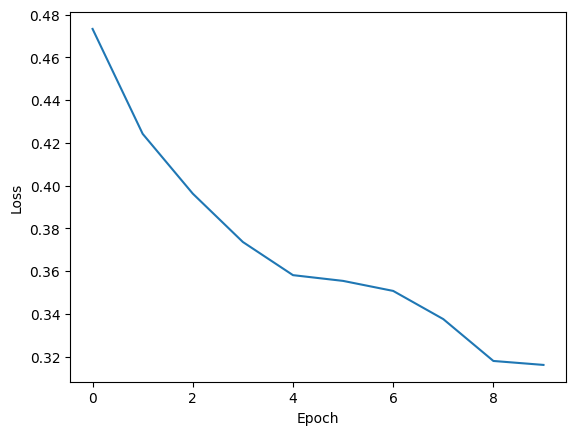

In [ ]:
plt.plot(np.array(callback.metrics))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## SASRec

### Sequentialize Data

In [ ]:
run_once=0
if run_once == 0:
  interaction_df['timestamp_unix'] = interaction_df['timestamp']
  run_once=1

seq_df = interaction_df.copy()
seq_df['timestamp'] = pd.to_datetime(seq_df['timestamp_unix'], unit='ms')

cols = ['rating', 'asin', 'timestamp', 'user_id']

seq_df['is_valid'] = seq_df.timestamp >= '2023-05-01'
seq_df = seq_df[seq_df.timestamp>'2010-01-01']
seq_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,timestamp_unix,is_valid
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,2021-01-14 00:45:35.448,0,True,1610585135448,False
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2018-11-21 15:15:24.549,0,True,1542813324549,False
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2016-12-21 12:42:38.000,0,True,1482324158000,False
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2014-11-15 21:10:00.000,1,True,1416085800000,False
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2013-02-26 22:33:14.000,2,True,1361917994000,False


In [ ]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

seq_df['user_id'] = user_encoder.fit_transform(seq_df['user_id'])
seq_df['asin'] = product_encoder.fit_transform(seq_df['asin'])

# sequentialize
cols = ['user_id', 'timestamp', 'asin', 'rating']
seq_df_gp = seq_df[cols].sort_values('timestamp').groupby('user_id').agg(list).reset_index()

# padding
max_len = 10
seq_df_gp[['rating', 'asin','timestamp']] = seq_df_gp[['rating', 'asin','timestamp']].\
                                            applymap(lambda x : x[:10] if len(x)>=10 else [0]*(max_len-len(x)) + x)

<ipython-input-18-c617345da4f0>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x : x[:10] if len(x)>=10 else [0]*(max_len-len(x)) + x)


In [ ]:
seq_df_gp.head()

,user_id,timestamp,asin,rating
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 2013-12-21 05:06:34, ...","[0, 0, 0, 0, 0, 0, 0, 0, 88945, 65230]","[0, 0, 0, 0, 0, 0, 0, 0, 4.0, 2.0]"
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 2013-06-16 14:29:07, ...","[0, 0, 0, 0, 0, 0, 0, 0, 83572, 91628]","[0, 0, 0, 0, 0, 0, 0, 0, 5.0, 5.0]"
2,2,"[0, 0, 0, 0, 0, 0, 0, 2013-08-21 00:03:46, 201...","[0, 0, 0, 0, 0, 0, 0, 20673, 54125, 78922]","[0, 0, 0, 0, 0, 0, 0, 5.0, 5.0, 5.0]"
3,3,"[0, 0, 0, 0, 0, 0, 0, 2015-02-04 20:28:44, 201...","[0, 0, 0, 0, 0, 0, 0, 75993, 62508, 60312]","[0, 0, 0, 0, 0, 0, 0, 5.0, 5.0, 5.0]"
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2013-10-05 14:16:28]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 62270]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 5.0]"


In [ ]:
len(seq_df_gp.timestamp)

48879

In [ ]:
class seqDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        user_id = torch.tensor(data['user_id'])
        product_id = torch.tensor(data['asin'])
        previous_ratings = torch.tensor(data['rating'])
        target_rating = torch.tensor(data['rating'][-1])


        return user_id, product_id, previous_ratings, target_rating

In [ ]:
dataset = seqDataset(seq_df_gp)

In [ ]:
dataset.__getitem__(44)

(tensor(44),
 tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0, 97109]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 5.]),
 tensor(5.))

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

### Model Architecture

In [ ]:
class PlTrainer(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.criterion = F.binary_cross_entropy

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    user_id, product_id, previous_ratings, target_rating = batch
    y_hat = self.forward(user_id, product_id, previous_ratings)

    import pdb
    pdb.set_trace()
    # stop point
    y_hat = y_hat.reshape((len(y_hat)*y_hat.shape[1], y_hat.shape[-1]))
    y = y.reshape((len(y)*y.shape[1], y.shape[-1]))
    ind = x['strt_ind'].view(-1) == True

    y_hat = y_hat[ind]
    y = y[ind]

    y_hat = y_hat[:, 1:]
    y = y[:, 1:]


    loss = self.criterion(y_hat, y)

    return loss

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [ ]:
class SaveMetricsCallback(pl.Callback):

    def __init__(self):
      super().__init__()
      self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the logs directly from the logger
        each_me = copy.deepcopy(trainer.callback_metrics['train_loss']).cpu().numpy()
        self.metrics.append(each_me)
        print(f"Epoch {trainer.current_epoch}: {trainer.callback_metrics}")

In [ ]:
class SASRec(PlTrainer):
    def __init__(self, n_tokens, embedding_dim, d_model,
                 num_heads, num_layers, dropout, max_len):
        super(SASRec, self).__init__()

        # P x d_model
        self.product_embedding = nn.Embedding(n_tokens, embedding_dim, padding_idx=0)
        self.position_embedding = nn.Embedding(max_len, embedding_dim) # len x d_model

        self.emb_dropout = nn.Dropout(dropout)

        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=num_heads,
                                                   dim_feedforward = embedding_dim,
                                                   dropout=dropout, batch_first=True)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)


        self.fc = nn.Linear(embedding_dim, n_tokens)
        self.max_len = max_len

    def forward(self, user_id, product_ids, previous_ratings):
        device = next(self.parameters()).device
        src_mask = (torch.tril(torch.rand(self.max_len, self.max_len).to(device))==0).bool()

        positions = torch.arange(previous_ratings.size(1), device=previous_ratings.device).\
                                                                    unsqueeze(0).\
                                                                    expand_as(previous_ratings) # Creates position for each previous rating


        product_embeddings = self.product_embedding(product_ids)
        previous_ratings = previous_ratings.unsqueeze(-1) * product_embeddings

        position_embeddings = self.position_embedding(positions)
        embeddings = product_embeddings + position_embeddings + previous_ratings
        embeddings = self.emb_dropout(embeddings) # batch, context_window, embedding_dim
        # embeddings = embeddings.permute(1, 0, 2)
        # import pdb
        # pdb.set_trace()
        transformer_out = self.transformer_encoder(embeddings, src_mask=src_mask)
        #transformer_out = transformer_out.permute(1, 0, 2)

        logits = self.fc(transformer_out)
        out = F.sigmoid(logits)
        return out

### Training Loop

In [ ]:
callback = SaveMetricsCallback()
trainer = pl.Trainer(max_epochs=1, callbacks=[callback])

n_items = interaction_df.asin.nunique()
embedding_size = 16

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

SASRec_model = SASRec(n_tokens=n_items,
                          embedding_dim=16, d_model=16,
                              num_heads=2, num_layers=1, dropout=.1, max_len=10)

trainer.fit(SASRec_model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params | Mode 
------------------------------------------------------------------------
0 | product_embedding   | Embedding               | 1.8 M  | train
1 | position_embedding  | Embedding               | 160    | train
2 | emb_dropout         | Dropout                 | 0      | train
3 | transformer_encoder | TransformerEncoderLayer | 1.7 K  | train
4 | fc                  | Linear                  | 1.9 M  | train
------------------------------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total pa

Training: |          | 0/? [00:00<?, ?it/s]

> <ipython-input-26-9d5e47bb23c7>(18)common_step()
     16     pdb.set_trace()
     17     # stop point
---> 18     y_hat = y_hat.reshape((len(y_hat)*y_hat.shape[1], y_hat.shape[-1]))
     19     y = y.reshape((len(y)*y.shape[1], y.shape[-1]))
     20     ind = x['strt_ind'].view(-1) == True

ipdb> y_hat.size()
torch.Size([256, 10, 113753])
ipdb> q


In [ ]:
!nvidia-smi

Fri Aug  2 14:32:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              34W /  70W |  14687MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
t = torch.zeros((10, 100, 1000))

In [ ]:
t.size()

torch.Size([10, 100, 1000])

In [ ]:
t.permute(1,0,2).size()

torch.Size([100, 10, 1000])

## Bert4Rec

## Sequential Model

In [ ]:
class seq_Dataset(Dataset):
  def __init__(self, cust_behavior, context_window=10)

    self.context_window = context_window
    self.product_features =
    self.cust_behavior = cust_behavior
    self.parent_idx = parent_idx_tensor

  def pad_df(self, cust_behavior):
    data = {}
    for col


  def __getitems__(self, idx):
    feature_token = self.get_values

In [ ]:
#interaction_df.sort_values('timestmap', ascending=False).groupby('user_id')['rating'].apply(lambda x: x)

In [ ]:
interaction_df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True
...,...,...,...,...,...,...,...,...,...,...
29474574,5.0,Daughter loved it,My daughter hugged the books on Christmas morn...,[],1454903597,1454903597,AF4K4X523XERW6VAM7TONCFJXTZQ,1388592808000,0,True
29474605,5.0,Oh Brothers!,Another terrific tale from Robert Ferrigno. N...,[],0375401253,0375401253,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012375362000,0,False
29474606,4.0,Bourne again?,I enjoyed this book. Partially because it was...,[],0385479611,0385479611,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012374866000,2,False
29474710,5.0,Five Stars,Fun class,[],1449697208,1449697208,AHHXPDYK3IVYF3ALMXZQT2VPSGZQ,1431893209000,0,True


In [ ]:
class PlTrainer(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.criterion = F.binary_cross_entropy

  def configure_callbacks(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x, causal=True)

    # stop point
    y_hat = y_hat.reshape((len(y_hat)*y_hat.shape[1], y_hat.shape[-1]))
    y = y.reshape((len(y)*y.shape[1], y.shape[-1]))
    ind = x['strt_ind'].view(-1) == True

    y_hat = y_hat[ind]
    y = y[ind]

    y_hat = y_hat[:, 1:]
    y = y[:, 1:]


    loss = self.criterion(y_hat, y)

    return loss

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int,
                  droupout: float=.1, max_len: int=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe) # registers for as part of model state, nontrainable parameter

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [ ]:
class TabTransformer(pl.LightningModule):
  def __init__(self, num_items, d_model, nhead,
               num_encoder_layers, dim_feedforward,
               max_len, dropout=0.1):
    self.d_model = d_model
    self.contextual_embedding = nn.TransformerEncoderLayer(
        d_model, nhead, dim_feedforward, dropout
    )

  def forward(self, x: list):
    xs = []
    b,t,c, = x[0].shape

    for feature in x:
      xs.append(feature.reshape((b*t, 1, c)))

    xs = torch.concatenate(xs, dim=1)
    xs = self.contextual_embedding(xs)
    xs = xs.reshape((b, t, c*len(x)))
    return xs

In [ ]:
class TransformerModel(PlTrainer):
  # embed seperately, then layer norm, # more dim for contexxtual dim,
  # multiple laters for self attention, layernorm, a couple linear layers to shrink size to final output


  def __init__(self, num_items, d_model, nhead,
                num_encoder_layers, dim_feedforward,
                max_len, dropout=0.1):
      super().__init__()
      self.item_embedding = nn.Embedding(num_items, d_model)
      self.position_embedding = PositionalEncoding(d_model, max_len)
      self.transformer_encoder = nn.TransformerEncoder(
          nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
          num_encoder_layers
      )
      self.norm = nn.LayerNorm(d_model)
      self.linear = nn.Linear(d_model, num_items)
      self.dropout = nn.Dropout(dropout)
      self.d_model = d_model

  @classmethod
  def from_pretrained(cls, PATH):

    params = json.load(open(PATH + '/params.json', 'r'))
    model = cls(**params)
    model.load_state_dict(torch.load(PATH+ '/model.json'))
    model.__dict__.update(params)
    model.params.update(params)
    return model

  def forward(self, src, src_mask):
      src = self.item_embedding(src) * np.sqrt(self.d_model)
      src = self.position_embedding(src)
      output = self.transformer_encoder(src)
      output = self.linear(output)


      # embedding layers
      self.norm(self.apex(src['apex']))

      # seasonal embeddings
      torch.sin(2*3.14*src['dow']/7)
      torch.cos(2*3.14*src['dow']/7)

      seasonal_embed = torch.cat([...])
      self.norm(self.seasonal_embed(seasonal_em))

      # SASRec
      item_em = self.product_embedding(src['seq'][:, :, -1]) #3d to 2D token embeddings
      item_em = self.prod_encoder(item_em) + seasonal_em
      item_encoded = self.item_encoder(item_em, src_mask=src_mask)


      item_encoded = self.item_encoder(item_em, src_mask=src_mask) + item_em # why add this back in?

      ft_em = self.contextual_em([...])
      output = self.norm(ft_em)
      output = self.linear(output)

      return output

  def save(self, PATH=None):
    """
    Save model to PATH
    """

    if not os.path.exists(PATH):
      os.makedirs(PATH)

    torch.save(self.state_dict(), PATH + '/model.json')
    params = {}

    for key, value in self.__dict__.items():
      if type(value) in (type('s'), type(1), type(1.)):
        params.update({key:value})
    json.dump(params, open(PATH + '/params.json', 'w'))
    self.params.updates(params)

## BERT from Scratch


Also build `TransformerEncoderLayer` from scratch

In [ ]:
vocab_size = 30000
n_segments = 3
max_len = 512
embedding_dim = 768
n_layers = 12
attn_heads = 12
dropout = .1

class BERTEmbedding(nn.Module):
  def __init__(self, vocab_size, n_segments, max_len, embedding_dim, dropout):
    super().__init__()

    self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
    self.seg_embedding = nn.Embedding(n_segments, embedding_dim)
    self.position_embedding = nn.Embedding(max_len, embedding_dim)

    self.drop = nn.Dropout(dropout)
    self.pos_inp = torch.tensor([i for i in range(max_len)])


  def forward(self, seq, seg):
    embed_val = self.token_embedding(seq) + self.seg_embedding(seg) + self.position_embedding(self.pos_inp)
    return embed_val

class BERT(nn.Module):
  def __init__(self,
               vocab_size,
               n_segments,
               max_len,
               embedding_dim,
               n_layers,
               attn_heads,
               dropout):
    super().__init__()

    self.embedding = BERTEmbedding(vocab_size, n_segments, max_len, embedding_dim, dropout)
    self.encoder_layer= nn.TransformerEncoderLayer(embedding_dim, attn_heads, embed_dim=4)
    self.encoder_block = nn.TransformerEncoder(self.encoder_layer, n_layers

  def forward(self, seq, seg):
    embed_val = self.embedding(seq, seg)
    output = self.encoder_block(embed_val

In [ ]:
sample_seq = torch.randint(high=vocab_size, size=[max_len])
sample_seg = torch.randint(high=n_segments, size=[max_len])

embedding = BERTEmbedding(vocab_size, n_segments, max_len, embedding_dim, n_layers, attn_heads, dropout)
embedding_tensor = embedding(sample_seq, sample_seg)

print(embedding_tensor.size())

torch.Size([512, 768])


## Coding from scratch

In [ ]:
import torch
import torch.nn
import numpy as np

In [ ]:
torch.arange(0, 10, dtype=torch.float).unsqueeze(1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
class InputEmbeddings(nn.Module):

  def __init__(self, d_model: int, vocab_size: int):
    super().__init__():
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * np.sqrt(self.d_model) # avoid saturating the softmax


class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float=.1, seq_len: int=5000):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # shape seq_len, d_model
    pe = torch.zeros(self.seq_len, self.d_model)
    position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-np.log(10000.0) / self.d_model))

  def forward(self, x):



In [ ]:
#exploring positon embedding

In [ ]:
vocab x seq



position = np.arange(0, 100)
np.ones((100, 20))

pe = position/10000**()
